In [1]:
# from jupyterthemes import jtplot
# jtplot.style()

# Titanic 
Here is a solution for titanic disaster. 

Data set is [here](https://www.kaggle.com/c/titanic)

## Importing Data 


In [2]:
import pandas as pd
import numpy as np
import os
TRAIN_PATH = 'datasets/titanic'
TEST_PATH = 'datasets/titanic'
def load_titanic_data(TRAIN_PATH, TEST_PATH):
    train_csv = os.path.join(TRAIN_PATH, 'train.csv')
    test_csv = os.path.join(TEST_PATH, 'test.csv')
    return pd.read_csv(train_csv), pd.read_csv(test_csv)

In [3]:
train_set, test_set = load_titanic_data(TRAIN_PATH, TEST_PATH)

### Shuffling 

In [4]:
train_set = train_set.sample(frac=1)

## Let see our beautiful data :D

In [5]:
train_set.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
import matplotlib.pyplot as plt
train_set.hist(figsize=(20, 15), bins=50)
plt.show()

<Figure size 2000x1500 with 9 Axes>

## Prune Our Data Set

In [7]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 582 to 665
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB


As you see some data have not value. For example Cabin is have a lots on null values

In [8]:
distinct_cabin_value = len(np.unique(train_set.Cabin.values.astype(np.str)))
distinct_cabin_value

148

There is 148 distinct value from 204 total non-null value. So this data probably can not Impute with mean and others. We **drop** it.

Other values can be Impute with Imputer.




In [9]:
distinct_ticket_value = len(np.unique(train_set.Ticket.values.astype(np.str)))
distinct_ticket_value

681

Ticket number is also an attribute which does not impact on our prediction because of number of their distinct values.

Also there is some unique values like **PassengerId** or **Name** which 

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
class DeleteExtraAttr(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.drop(["Cabin", "PassengerId"], axis=1)

In [11]:
delete_attr = DeleteExtraAttr()
train_set_deleted = delete_attr.transform(train_set)
test_set_deleted = delete_attr.transform(test_set)
train_set_deleted.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
582,0,2,"Downton, Mr. William James",male,54.0,0,0,28403,26.000,S
324,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.550,S
820,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.500,S
311,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375,C
732,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.000,S


Also we can just get `Mr`, `Ms`, ... from name

In [12]:
train_set_pruned = train_set_deleted.copy()
test_set_pruned = test_set_deleted.copy()
train_set_pruned['Name'] = train_set_pruned['Name'].apply(lambda l: l.split(',')[1].split('.')[0][1:])
test_set_pruned['Name'] = test_set_pruned['Name'].apply(lambda l: l.split(',')[1].split('.')[0][1:])
train_set_pruned.head()
pd.crosstab(train_set_pruned['Name'], [train_set_pruned['Sex'] ,train_set_pruned['Survived']])

Sex          female      male    
Survived          0    1    0   1
Name                             
Capt              0    0    1   0
Col               0    0    1   1
Don               0    0    1   0
Dr                0    1    4   2
Jonkheer          0    0    1   0
Lady              0    1    0   0
Major             0    0    1   1
Master            0    0   17  23
Miss             55  127    0   0
Mlle              0    2    0   0
Mme               0    1    0   0
Mr                0    0  436  81
Mrs              26   99    0   0
Ms                0    1    0   0
Rev               0    0    6   0
Sir               0    0    0   1
the Countess      0    1    0   0

In [13]:
class SmoothOutName(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset['Name'] = dataset['Name'].replace(['the Countess', 'Sir', 'Rev', 'Major', 'Lady',
                                                  'Jonkheer', 'Dr', 'Don', 'Col', 'Capt'], 'Rare')
        dataset['Name'] = dataset['Name'].replace(['Mme', 'Mrs', 'Ms', 'Mlle', 'Miss'], 'Miss')
        return dataset

In [14]:
train_set_pruned = SmoothOutName().transform(train_set_pruned)
test_set_pruned = SmoothOutName().transform(test_set_pruned)

In [15]:
pd.crosstab(train_set_pruned['Name'], [train_set_pruned['Sex'] ,train_set_pruned['Survived']])

Sex      female      male    
Survived      0    1    0   1
Name                         
Master        0    0   17  23
Miss         81  230    0   0
Mr            0    0  436  81
Rare          0    3   15   5





## Ploting our remained attributes to see what we have

### Correlations

In [16]:
corr_matrix = train_set.corr()
corr_matrix['Survived'].sort_values()

Pclass        -0.338481
Age           -0.077221
SibSp         -0.035322
PassengerId   -0.005007
Parch          0.081629
Fare           0.257307
Survived       1.000000
Name: Survived, dtype: float64

In [17]:
corr_matrix['Survived'].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

### Visualization

In [18]:
train_set_pruned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
582,0,2,Mr,male,54.0,0,0,28403,26.000,S
324,0,3,Mr,male,NaN,8,2,CA. 2343,69.550,S
820,1,1,Miss,female,52.0,1,1,12749,93.500,S
311,1,1,Miss,female,18.0,2,2,PC 17608,262.375,C
732,0,2,Mr,male,NaN,0,0,239855,0.000,S


In [19]:
is_male = train_set_pruned['Sex'] == 'male'
survived_or_not = train_set_pruned['Survived'] == 1
male_survived = train_set_pruned[is_male & survived_or_not]
female_survived = train_set_pruned[~is_male & survived_or_not]
male_not_survived = train_set_pruned[is_male & ~survived_or_not]
female_not_survived = train_set_pruned[~is_male & ~survived_or_not]

(81, 233)

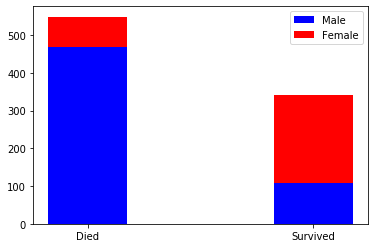

In [20]:
male_aliveness = (len(male_not_survived), len(male_survived))
female_aliveness = (len(female_not_survived), len(female_survived))
p1 = plt.bar(('Died', 'Survived'), male_aliveness , 0.35, color="b")
p2 = plt.bar(('Died', 'Survived'), female_aliveness , 0.35, color="r", bottom=male_aliveness)
plt.legend((p1[0], p2[0]), ('Male', 'Female'))
female_aliveness

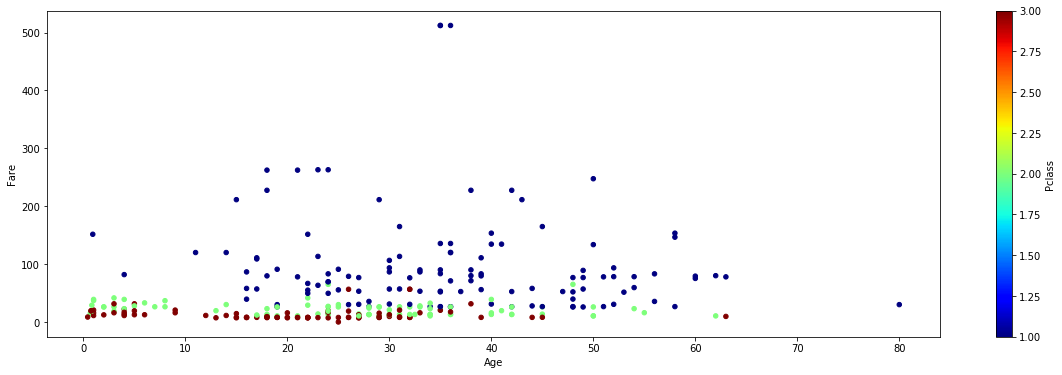

In [21]:
titanic_survived = train_set_pruned[train_set_pruned['Survived'] == 1]
fig,ax1=plt.subplots()
titanic_survived.plot(kind="scatter", x="Age", y="Fare",
                      c="Pclass", cmap=plt.get_cmap("jet"), figsize=(20, 6), ax=ax1)

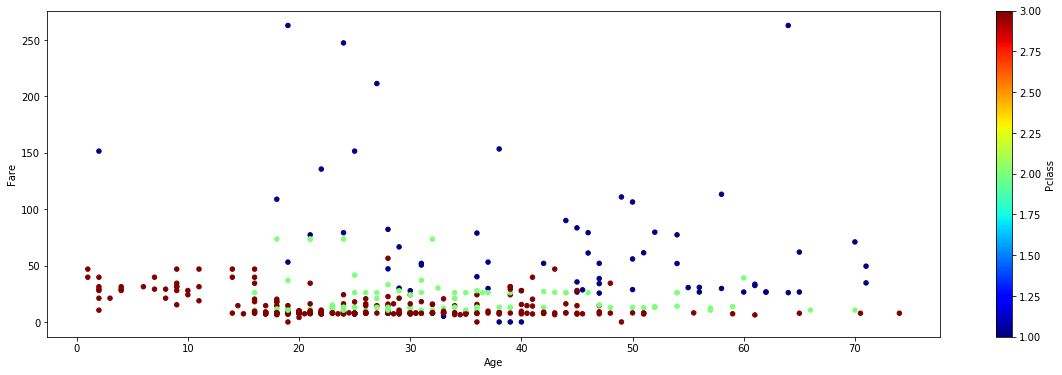

In [22]:
titanic_died = train_set_pruned[train_set_pruned['Survived'] == 0]
fig,ax1=plt.subplots()
titanic_died.plot(kind="scatter", x="Age", y="Fare",
                      c="Pclass", cmap=plt.get_cmap("jet"), figsize=(20, 6), ax=ax1)

Know we can delete some datas with some threshold. Data with Age > 70 and Fare > 300 is useless.


In [23]:
train_set_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 582 to 665
Data columns (total 10 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 76.6+ KB


In [24]:
median = train_set_pruned['Age'].median()
train_set_pruned['Age'] = train_set_pruned['Age'].fillna(median)
test_set_pruned['Age'] = test_set_pruned['Age'].fillna(median)
age_cond = train_set_pruned['Age'] < 70 
fare_cond = train_set_pruned['Fare'] < 300
train_set_v = train_set_pruned[ age_cond & fare_cond ]
# test_set_pruned['Age'] = test_set_pruned['Age'].fillna(median)

In [25]:
train_set_v.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 582 to 665
Data columns (total 10 columns):
Survived    881 non-null int64
Pclass      881 non-null int64
Name        881 non-null object
Sex         881 non-null object
Age         881 non-null float64
SibSp       881 non-null int64
Parch       881 non-null int64
Ticket      881 non-null object
Fare        881 non-null float64
Embarked    879 non-null object
dtypes: float64(2), int64(4), object(4)
memory usage: 75.7+ KB


We can classify our age in some groups


[0, 17],
[17, 37],
[37, 49],
[49, 66],

In [26]:
class AgeGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset.loc[ dataset['Age'] <= 16, 'AgeGP'] = 0
        dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 37), 'AgeGP'] = 1
        dataset.loc[(dataset['Age'] > 37) & (dataset['Age'] <= 49), 'AgeGP'] = 2
        dataset.loc[(dataset['Age'] > 49) & (dataset['Age'] <= 66), 'AgeGP'] = 3
        dataset.loc[ dataset['Age'] > 66, 'Age'] = 4
        dataset['Age*Class'] = dataset['AgeGP'] * dataset['Pclass']
        return dataset
train_set_pruned = AgeGrouper().transform(train_set_v)
test_set_pruned = AgeGrouper().transform(test_set_pruned)

In [27]:
class FareGrouper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset.loc[ dataset['Fare'] <= 50, 'FareGP'] = 0
        dataset.loc[(dataset['Fare'] > 50) & (dataset['Fare'] <= 100), 'FareGP'] = 1
        dataset.loc[(dataset['Fare'] > 100) & (dataset['Fare'] <= 150), 'FareGP'] = 2
        dataset.loc[(dataset['Fare'] > 150) & (dataset['Fare'] <= 200), 'FareGP'] = 3
        dataset.loc[(dataset['Fare'] > 200) & (dataset['Fare'] <= 250), 'FareGP'] = 4
        dataset.loc[(dataset['Fare'] > 250) & (dataset['Fare'] <= 300), 'FareGP'] = 5
        dataset.loc[ dataset['Fare'] > 300, 'Fare'] = 6
        return dataset
train_set_pruned = FareGrouper().transform(train_set_pruned)
test_set_pruned = FareGrouper().transform(test_set_pruned)

Family attribute say that person has family or not. 

In [28]:
class IsAloneDecider(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        dataset = X.copy()
        dataset['Family'] = dataset['SibSp'] + dataset['Parch']
        dataset['isAlone'] = (dataset['Family'] > 0).astype(np.int)
        return dataset
train_set_pruned = IsAloneDecider().transform(train_set_pruned)
test_set_pruned = IsAloneDecider().transform(test_set_pruned)

#### Some Tips
* As you see pclass doesn't mean less fare! 
* There is more 1st class in survived and more 3d class in died people
* Childrens of second and first class not died.

In [29]:
class AddTicketCat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.set = []
        start = 0
        last = 0
        dataset = X.sort_values('Ticket')
        for index, row in dataset.iterrows():
            if row['Survived'] == 1 and start == 0 :
                start = row['Ticket']
            if row['Survived'] == 0 and not start == 0 :
                self.set.append((start, last))
                start = 0
            last = row['Ticket']
        return self
    def transform(self, X, y=None):
        dataset = X.sort_values('Ticket')
        for index, row in dataset.iterrows():
            for period in self.set:
                if row['Ticket'] >= period[0] and row['Ticket'] <= period[1]:
                    dataset.at[index, 'TicketCat'] = np.int64(1)
                    break
                else :
                    dataset.at[index, 'TicketCat'] = np.int64(0)
        return dataset
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    

In [30]:
add_ticket_cat = AddTicketCat()
train_set_pruned = add_ticket_cat.fit_transform(train_set_pruned)
test_set_pruned = add_ticket_cat.transform(test_set_pruned)
train_set_pruned

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGP,Age*Class,FareGP,Family,isAlone,TicketCat
759,1,1,Rare,female,33.0,0,0,110152,86.5000,S,1.0,1.0,1.0,0,0,1.0
504,1,1,Miss,female,16.0,0,0,110152,86.5000,S,0.0,0.0,1.0,0,0,1.0
257,1,1,Miss,female,30.0,0,0,110152,86.5000,S,1.0,1.0,1.0,0,0,1.0
262,0,1,Mr,male,52.0,1,1,110413,79.6500,S,3.0,3.0,1.0,2,1,1.0
585,1,1,Miss,female,18.0,0,2,110413,79.6500,S,1.0,1.0,1.0,2,1,1.0
558,1,1,Miss,female,39.0,1,1,110413,79.6500,S,2.0,2.0,1.0,2,1,1.0
475,0,1,Mr,male,28.0,0,0,110465,52.0000,S,1.0,1.0,1.0,0,0,0.0
110,0,1,Mr,male,47.0,0,0,110465,52.0000,S,2.0,2.0,1.0,0,0,0.0
430,1,1,Mr,male,28.0,0,0,110564,26.5500,S,1.0,1.0,0.0,0,0,1.0
366,1,1,Miss,female,60.0,1,0,110813,75.2500,C,3.0,3.0,1.0,1,1,1.0


## Clean Rest Of Data

We remove some column and here we just remove nulls with median strategy.


In [31]:
train_set_pruned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 759 to 540
Data columns (total 16 columns):
Survived     881 non-null int64
Pclass       881 non-null int64
Name         881 non-null object
Sex          881 non-null object
Age          881 non-null float64
SibSp        881 non-null int64
Parch        881 non-null int64
Ticket       881 non-null object
Fare         881 non-null float64
Embarked     879 non-null object
AgeGP        881 non-null float64
Age*Class    881 non-null float64
FareGP       881 non-null float64
Family       881 non-null int64
isAlone      881 non-null int64
TicketCat    881 non-null float64
dtypes: float64(6), int64(6), object(4)
memory usage: 157.0+ KB


Because we have a lots of data in age and it can computed with mean

### Make some transformers for our pipline
Label Binarizer and Label Encoder should reimplement for pipelines. also a DataFrameSelector should be implemented to every pipeline. 

In [32]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MultiLabelBinarizer
class LabelBinarizerPipelineFriendly(MultiLabelBinarizer):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
        super(LabelBinarizerPipelineFriendly,self).fit(X)
    def transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).transform(X)
    def fit_transform(self, X, y=None):
        return super(LabelBinarizerPipelineFriendly, self).fit(X).transform(X)

class LabelEncoderPiplineFriendly(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        """this would allow us to fit the model based on the X input."""
#         super(LabelEncoderPiplineFriendly,self).fit(X)
        return self
    def transform(self, X, y=None):
#         return super(LabelEncoderPiplineFriendly, self).transform(X).reshape(-1, 1)
        X = pd.DataFrame(X)
        return X.apply(LabelEncoder().fit_transform)
    def fit_transform(self, X, y=None):
        r = self.transform(X, y)
        return r

In [33]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attrs):
        self.attrs = attrs
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X[self.attrs]
    

In [34]:
train_set_pruned.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGP,Age*Class,FareGP,Family,isAlone,TicketCat
759,1,1,Rare,female,33.0,0,0,110152,86.50,S,1.0,1.0,1.0,0,0,1.0
504,1,1,Miss,female,16.0,0,0,110152,86.50,S,0.0,0.0,1.0,0,0,1.0
257,1,1,Miss,female,30.0,0,0,110152,86.50,S,1.0,1.0,1.0,0,0,1.0
262,0,1,Mr,male,52.0,1,1,110413,79.65,S,3.0,3.0,1.0,2,1,1.0
585,1,1,Miss,female,18.0,0,2,110413,79.65,S,1.0,1.0,1.0,2,1,1.0


In [35]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder, MultiLabelBinarizer

# num_attrs = ['Pclass', 'Age', 'Fare', 'Family', 'Age*Class']
num_attrs = ['Pclass', 'AgeGP', 'FareGP', 'Age*Class' , 'isAlone']
# label_attrs = ['Embarked', 'Sex', 'Name']
label_attrs = ['Embarked', 'Sex', 'Name']
# sex_attrs = ['Name']
all_atrrs = num_attrs + ['Embarked1', 'Embarked2', 'Embarked3'] + ['Sex1', 'Sex2'] + ['Name1', 'Name2', 'Name3', 'Name4']

numbers_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attrs)),
    ('imputer', SimpleImputer(strategy='median')),
#     ('std_scaler', StandardScaler()),
])

labels_pipeline = Pipeline([
    ('selector', DataFrameSelector(label_attrs)),
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('one_hot', LabelBinarizerPipelineFriendly()),
#     ('std_scaler', StandardScaler()),
])

# sex_pipeline = Pipeline([
#     ('selector', DataFrameSelector(sex_attrs)),
#     ('encoder',LabelEncoderPiplineFriendly()),
#     ('std_scaler', StandardScaler()),
# ])

full_pipeline = FeatureUnion([
    ('num_pipeline', numbers_pipeline),
    ('label_pipeline', labels_pipeline),
#     ('sex_pipeline', sex_pipeline),
])

labels = train_set_pruned['Survived'].values
clean_data = full_pipeline.fit_transform(train_set_pruned).astype(int)
clean_data_df = pd.DataFrame(clean_data, columns=all_atrrs)

In [36]:
clean_data_df.head()

,Pclass,AgeGP,FareGP,Age*Class,isAlone,Embarked1,Embarked2,Embarked3,Sex1,Sex2,Name1,Name2,Name3,Name4
0,1,1,1,1,0,0,0,0,0,0,1,1,1,0
1,1,0,1,0,0,0,0,1,0,0,0,1,1,0
2,1,1,1,1,0,0,0,1,0,0,0,1,1,0
3,1,3,1,3,1,0,0,0,1,0,0,1,0,1
4,1,1,1,1,1,0,0,1,0,0,0,1,1,0


In [37]:
some_person = clean_data[10]
some_person_label = labels[10]

## Do The Magic (Classification)

### SGD Classification

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate
sgd_model = SGDClassifier()
sgd_model.fit(clean_data, labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [39]:
sgd_model.predict([some_person])

array([0])

### Check SGD Scores

In [40]:
from sklearn.model_selection import cross_val_score, cross_val_predict
sgd_scores = cross_val_score(sgd_model, clean_data, labels, cv=3, scoring="accuracy")
sgd_scores

array([0.82312925, 0.70068027, 0.73037543])

In [41]:
from sklearn.metrics import f1_score
sgd_pred = cross_val_predict(sgd_model, clean_data, labels, cv=3)
f1_score(labels, sgd_pred)

0.6066176470588235

### Random Forest Calssification

In [42]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(clean_data, labels)
rf_model.predict([some_person])

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0])

### Check Random Forest Scores


In [43]:
rf_scores = cross_val_score(rf_model, clean_data, labels, cv=3, scoring="accuracy")
rf_scores

array([0.77891156, 0.75510204, 0.76109215])

In [44]:
rf_pred = cross_val_predict(rf_model, clean_data, labels, cv=3)
f1_score(labels, rf_pred)

0.653250773993808

### Tuning Random Forest

In [45]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 1, 2, 3, 4, 5, 6, 7]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 110, num = 24)]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestClassifier()

In [46]:
random_search =  RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                                    n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring="accuracy")
random_search.fit(clean_data, labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [47]:
best_estimator = random_search.best_estimator_
best_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=57, max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=522,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [48]:
rf_scores = cross_val_score(best_estimator, clean_data, labels, cv=2, scoring="accuracy")
rf_scores

array([0.80498866, 0.78636364])

In [49]:
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=522,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
                       max_depth=None, max_features=7, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=522,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### RBF Classification

In [50]:
from sklearn.svm import SVC
rbf_model = SVC(kernel="rbf", gamma="scale")
rbf_model.fit(clean_data, labels)
rbf_model.predict([some_person])

array([0])

### Check RBF Scores

In [51]:
rbf_scores = cross_val_score(rbf_model, clean_data, labels, cv=3, scoring="accuracy")
rbf_scores

array([0.81292517, 0.76870748, 0.77474403])

In [52]:
rbf_pred = cross_val_predict(rbf_model, clean_data, labels, cv=3)
f1_score(labels, rbf_pred)

0.7096774193548387

### Gaussian Classification

In [53]:
from sklearn.gaussian_process import GaussianProcessClassifier
gs_model = GaussianProcessClassifier()
gs_model.fit(clean_data, labels)
gs_model.predict([some_person])

array([0])

In [54]:
gs_scores = cross_val_score(gs_model, clean_data, labels, cv=3, scoring="accuracy")
gs_scores

array([0.81972789, 0.76530612, 0.77133106])

### KNeighbors classification

In [55]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 3)
knn_model.fit(clean_data, labels)
knn_model.predict([some_person])

array([0])

In [56]:
knn_scores = cross_val_score(knn_model, clean_data, labels, cv=3, scoring="accuracy")
knn_scores

array([0.71088435, 0.73129252, 0.74061433])

### Decision Tree

In [57]:
from sklearn.tree import DecisionTreeClassifier
dec_model = DecisionTreeClassifier()
dec_model.fit(clean_data, labels)
dec_scores = cross_val_score(dec_model, clean_data, labels, cv=3, scoring="accuracy")
dec_scores

array([0.77210884, 0.74489796, 0.74061433])

## Improve our selection


In [58]:
from sklearn.model_selection import GridSearchCV

grid_dist = [
    {'kernel':['linear'], 'C' : range(1, 10),},
    {'kernel':['rbf'], 'C' : range(1, 10), 'gamma' : ['auto', 'scale']},
    {'kernel':['poly'], 'C' : range(1, 10), 'gamma' : ['auto', 'scale']}
]
svc = SVC()
grid_search = GridSearchCV(svc, grid_dist, verbose=1, n_jobs=-1, scoring='accuracy', cv=3)
# grid_search.fit(clean_data, labels)

In [59]:
# grid_search.best_score_

In [60]:
test_set_pruned.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,AgeGP,Age*Class,FareGP,Family,isAlone,TicketCat
335,1,Mr,male,30.0,0,0,110469,26.00,S,1.0,1.0,0.0,0,0,0.0
158,1,Mr,male,42.0,0,0,110489,26.55,S,2.0,2.0,0.0,0,0,0.0
236,1,Mr,male,64.0,1,0,110813,75.25,C,3.0,3.0,1.0,1,1,1.0
191,1,Mr,male,28.0,0,0,111163,26.00,S,1.0,1.0,0.0,0,0,0.0
266,1,Mr,male,28.0,0,0,112051,0.00,S,1.0,1.0,0.0,0,0,0.0


In [61]:
test_set_features = full_pipeline.transform(test_set_pruned).astype(int)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['Dona'] will be ignored
  .format(sorted(unknown, key=str)))


In [62]:
# best_estimator = grid_search.best_estimator_
best_estimator.fit(clean_data, labels)
predictions = best_estimator.predict(test_set_features)

In [63]:
final_prediction = pd.DataFrame({'PassengerId': test_set['PassengerId'],
                                'Survived': predictions})
final_prediction.tail()

,PassengerId,Survived
413,1305,1
414,1306,0
415,1307,0
416,1308,0
417,1309,1


In [64]:
test_set[test_set['PassengerId'] == 1306]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C


In [65]:
answer_csv = os.path.join(TEST_PATH, 'test_answer.csv')
last_csv = pd.read_csv(answer_csv)

In [66]:
final_prediction.to_csv(answer_csv, index=False)

In [67]:
newdf=pd.concat([last_csv,final_prediction]).drop_duplicates(keep=False)

In [68]:
newdf


,PassengerId,Survived
2,894,1
6,898,0
7,899,0
8,900,0
9,901,0
14,906,0
15,907,0
18,910,0
19,911,0
20,912,1
